# **METK Barley SNP-Chip:** Exploring the correlation between barley’s genetic makeup and its protein content
## Importing and editing the necessary datasets

In [1]:
import pandas as pd
import numpy as np
snip_data = pd.read_csv("SNIP_DATA.csv")
barley_data = pd.read_csv("BARLEY_DATA.csv")

In [2]:
# Giving the first column in "SNIP_DATA.csv" a header since it was originally unnamed
snip_data.rename(columns={snip_data.columns[0]: 'SNP'}, inplace=True)

# Dropping ID column for "BARLEY_DATA.csv"
barley_data = barley_data.drop(columns='Id')

## Cleaning dataset 'SNIP_DATA.csv' based on the following criteria: 
### 1. Handling 'failed' values by replacing them with NaN

In [3]:
snip_data.replace('failed', np.nan, inplace=True)

### 2. Removing SNPs with the same allele across all varieties

In [4]:
# Excluding the first column
snp_columns = snip_data.columns[1:]

# Filtering rows where there's more than one unique value in the SNP columns 
# This ignores NaN values so that if the row is ["A", "A", "A", "A", NaN, NaN] then it is still removed although there's 2 different values
snip_data = snip_data[snip_data[snp_columns].apply(lambda row: row.dropna().nunique() > 1, axis=1)]

### 3. Removing barley varieties that are not present in both datasets

In [5]:
# Function to normalize variety names because
# in dataset barley_data some varieties presented in form '5777.7.1.2' are written as 5777712 in snip_data
def normalize_variety_names(variety):
    return str(variety).replace('.', '')

In [6]:
# Normalizing variety names in barley_data
barley_data['Nimi'] = barley_data['Nimi'].apply(normalize_variety_names)

# Extracting variety names from snip_data (columns starting from the second column)
snip_varieties = set(snip_data.columns[1:])

# Extracting variety names from barley_data (row values in the appropriate column)
barley_varieties = set(barley_data['Nimi'])

# Finding common varieties
common_varieties = snip_varieties.intersection(barley_varieties)

# Filtering snip_data to keep only common varieties
snip_data = snip_data[['SNP'] + list(common_varieties)]

# Filtering barley_data to keep only rows with common varieties
barley_data = barley_data[barley_data['Nimi'].isin(common_varieties)]

## Processing the datasets 
### **In preparation for finding correlations between protein content and genetic makeup**

In [7]:
# Creating a copy with only the barley variety and protein columns
protein_data = barley_data[['Nimi', 'Proteiin']].copy()

### Merging datasets on variety name

In [8]:
# Transposing snip_data to have barley varieties as rows not columns
snip_data_transposed = snip_data.set_index('SNP').T.reset_index()
snip_data_transposed.rename(columns={'index': 'Nimi'}, inplace=True)


# Merging protein_data with the transposed snip_data
merged_data = protein_data.merge(snip_data_transposed, on='Nimi', how='inner')


### Seeing what different types of values we have as alleles

In [9]:
# Extracting allele columns
allele_columns = merged_data.columns[2:]

# Flattening all values from allele columns into a single series and dropping NaN
all_alleles = merged_data[allele_columns].stack().dropna()

# Counting the occurrences of each allele value
allele_counts = all_alleles.value_counts()

print(allele_counts)

G    562756
A    540192
C    492895
T    429012
R      2030
Y      1405
K       466
M       416
S        82
W        45
Name: count, dtype: int64


**Brief biological explanation:**

| Nucleotide Symbol | Full Name                       |
|-------------------|---------------------------------|
| A                 | Adenine                         |
| C                 | Cytosine                        |
| G                 | Guanine                         |
| T                 | Thymine                         |
| R                 | Guanine / Adenine (purine)      |
| Y                 | Cytosine / Thymine (pyrimidine) |
| K                 | Guanine / Thymine               |
| M                 | Adenine / Cytosine              |
| S                 | Guanine / Cytosine              |
| W                 | Adenine / Thymine               |


### Creating numeric values for alleles and imputing NaN values


In [10]:
from sklearn.impute import KNNImputer


# Encoding non-numeric data: assigning integer values to each allele type
allele_mapping = {
    'A': 0,
    'C': 1,
    'G': 2,
    'T': 3,
    'R': 4,
    'Y': 5,
    'K': 6,
    'M': 7,
    'S': 8,
    'W': 9
}

# Apply encoding to SNP columns
columns_to_impute = merged_data.drop(['Nimi', 'Proteiin'], axis=1)
encoded_columns = columns_to_impute.map(lambda x: allele_mapping.get(x, np.nan))  

# creating a data frame from the list
Before_imputation = pd.DataFrame(encoded_columns)

# create an object for KNNImputer
imputer = KNNImputer(n_neighbors=5)
After_imputation = imputer.fit_transform(Before_imputation)

# Convert the result back to a DataFrame with the original column names
After_imputation_df = pd.DataFrame(After_imputation, columns=columns_to_impute.columns)

# Add the 'Nimi' and 'Proteiin' columns back to the imputed dataset
merged_data = pd.concat([merged_data[['Nimi', 'Proteiin']], After_imputation_df], axis=1)

# Display the final imputed dataset
merged_data




,Nimi,Proteiin,BK_01,BK_03,BK_05,BK_08,BK_10,BK_12,BK_14,BK_17,...,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0388,TGBA15K-TG0395,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
0,Amidala,12.2,3.0,3.0,1.0,2.0,0.6,0.0,0.0,1.0,...,1.0,3.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
1,Amy,12.7,3.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,3.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
2,Anneli,13.0,3.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,...,1.0,2.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,0.0
3,Anni,12.4,3.0,3.0,1.0,1.0,0.0,0.0,0.0,2.0,...,1.0,3.0,3.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
4,Annika,11.2,3.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,3.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,6006142,12.1,3.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,3.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
167,6006153,11.3,3.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,3.0,2.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
168,6011421,11.4,3.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,3.0,3.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0
169,6012243,11.6,3.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,...,1.0,3.0,3.0,2.0,1.0,0.0,3.0,3.0,1.0,2.0


Each SNP is represented as multiple binary columns, one for each **observed** allele. For instance, if a SNP site had the alleles "A," "C," and "T," it would be encoded as three separate columns (e.g., SNP_A, SNP_C, SNP_T), where a value of True signifies the presence of that allele, and False indicates its absence.

**Let's look at our encoded dataset:**

### Removing SNP markers with 99% similarity rate

In [11]:
print("Before filtering: ", merged_data.shape)

# Threshold for similarity rate
similarity_threshold = 0.99

# Function to calculate the similarity rate for each column
def calculate_similarity_rate(column):
    most_frequent_allele_count = column.value_counts(normalize=True).max()
    return most_frequent_allele_count

# Apply the function to each column in the SNP data
similarity_rates = merged_data.apply(calculate_similarity_rate, axis=0)

# Identify columns to keep (similarity rate below the threshold)
columns_to_keep = similarity_rates[similarity_rates < similarity_threshold].index

# Filter the DataFrame to keep only the selected columns
filtered_data = merged_data[columns_to_keep]

print("After filtering: ", filtered_data.shape)
filtered_data


Before filtering:  (171, 11898)
After filtering:  (171, 10813)


,Nimi,Proteiin,BK_01,BK_03,BK_05,BK_08,BK_10,BK_17,BK_19,BOPA1_10012-1239,...,TGBA15K-TG0382,TGBA15K-TG0383,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0386,TGBA15K-TG0400,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
0,Amidala,12.2,3.0,3.0,1.0,2.0,0.6,1.0,2.0,0.0,...,1.0,3.0,1.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0
1,Amy,12.7,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,3.0,1.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0
2,Anneli,13.0,3.0,3.0,3.0,2.0,0.0,1.0,2.0,0.0,...,1.0,1.0,1.0,2.0,2.0,0.0,3.0,3.0,1.0,0.0
3,Anni,12.4,3.0,3.0,1.0,1.0,0.0,2.0,2.0,0.0,...,1.0,3.0,1.0,3.0,3.0,0.0,3.0,3.0,1.0,2.0
4,Annika,11.2,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,3.0,1.0,1.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,6006142,12.1,3.0,3.0,1.0,1.0,0.0,1.0,2.0,4.0,...,1.0,1.0,1.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0
167,6006153,11.3,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,1.0,1.0,3.0,2.0,0.0,3.0,3.0,1.0,2.0
168,6011421,11.4,3.0,3.0,1.0,1.0,0.0,1.0,2.0,0.0,...,1.0,3.0,1.0,3.0,3.0,0.0,3.0,3.0,1.0,2.0
169,6012243,11.6,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,3.0,1.0,3.0,3.0,0.0,3.0,3.0,1.0,2.0


### Filter based on correlation to protein content

In [12]:
filtered_data_without_protein_name = filtered_data.drop(columns=['Proteiin', 'Nimi'])

correlations = filtered_data_without_protein_name.corrwith(filtered_data['Proteiin'])

# Set a threshold for correlation
correlation_threshold = 0.05

# Filter SNP markers based on the threshold
filtered_columns = correlations[abs(correlations) >= correlation_threshold].index

# Subset the merged_data to include only relevant columns
double_filtered_data = filtered_data[['Nimi', 'Proteiin'] + list(filtered_columns)]
double_filtered_data

,Nimi,Proteiin,BK_01,BK_03,BK_05,BK_08,BK_10,BK_17,BOPA1_10012-1239,BOPA1_1007-651,...,TGBA15K-TG0380,TGBA15K-TG0381,TGBA15K-TG0382,TGBA15K-TG0383,TGBA15K-TG0384,TGBA15K-TG0385,TGBA15K-TG0402_NC_MA,TGBA15K-TG0402_NG_MA,TGBA15K-TG0403,TGBA15K-TG0409
0,Amidala,12.2,3.0,3.0,1.0,2.0,0.6,1.0,0.0,2.0,...,1.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0
1,Amy,12.7,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,3.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0
2,Anneli,13.0,3.0,3.0,3.0,2.0,0.0,1.0,0.0,2.0,...,3.0,3.0,1.0,1.0,1.0,2.0,3.0,3.0,1.0,0.0
3,Anni,12.4,3.0,3.0,1.0,1.0,0.0,2.0,0.0,0.0,...,1.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0
4,Annika,11.2,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,6006142,12.1,3.0,3.0,1.0,1.0,0.0,1.0,4.0,2.0,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,2.0
167,6006153,11.3,3.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,2.0
168,6011421,11.4,3.0,3.0,1.0,1.0,0.0,1.0,0.0,2.0,...,1.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0
169,6012243,11.6,3.0,3.0,1.0,2.0,0.0,1.0,2.0,0.0,...,1.0,1.0,1.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0


### Performing one-hot encoding

## Finding correlations

### Simple Linear, Lasso, and Ridge Regression Models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features and target
X = double_filtered_data.drop(columns=['Proteiin', 'Nimi'])
y = double_filtered_data['Proteiin']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()

# Fit the models on the training data
linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

# Calculate MSE for each model
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Linear Regression:")
print(f"R^2 Score: {r2_score(y_test, y_pred_linear)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_linear)}")

print("\nRidge Regression:")
print(f"R^2 Score: {r2_score(y_test, y_pred_ridge)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_ridge)}")

print("\nLasso Regression:")
print(f"R^2 Score: {r2_score(y_test, y_pred_lasso)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lasso)}")

Linear Regression:
R^2 Score: 0.08521734476512666
Mean Squared Error: 0.5374142740133299

Ridge Regression:
R^2 Score: 0.08899749797020007
Mean Squared Error: 0.5351935188659314

Lasso Regression:
R^2 Score: -0.203715366580981
Mean Squared Error: 0.7071557556846276


The low R² score suggests that the linear regression models struggle to capture the relationship between SNP markers and protein content, or the relationship is weak.

### Dimensionality Reduction with PCA (Principal Component Analysis)

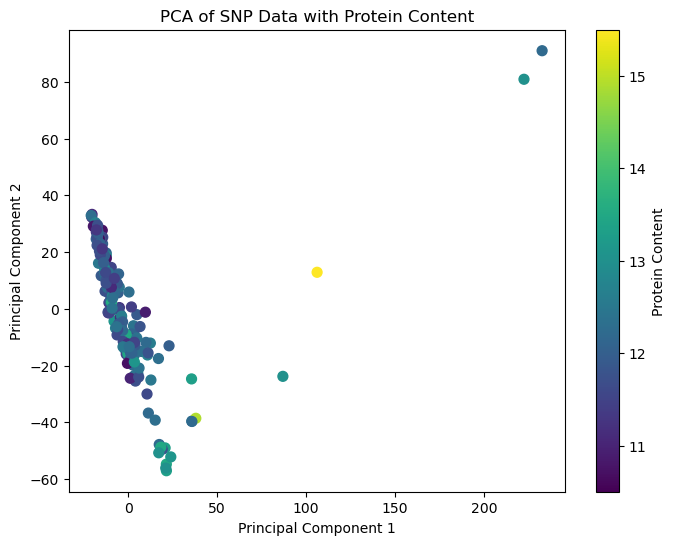

Explained variance ratio by the components: [0.11029141 0.0661894 ]


In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract SNP data (drop the 'Nimi' and 'Proteiin' columns)
X_snp = double_filtered_data.drop(columns=['Nimi', 'Proteiin'])

# Standardizing the SNP data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_snp)

# Apply PCA to reduce dimensions
pca = PCA(n_components=2)  # Let's start by reducing to 2 components for visualization
pca_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])

# Add the 'Nimi' and 'Proteiin' columns for easy analysis
pca_df['Proteiin'] = double_filtered_data['Proteiin']
pca_df['Nimi'] = double_filtered_data['Nimi']

# Plot the PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Proteiin'], cmap='viridis', s=50)
plt.colorbar(label='Protein Content')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of SNP Data with Protein Content')
plt.show()

# Check the explained variance by the principal components
print(f"Explained variance ratio by the components: {pca.explained_variance_ratio_}")


In [16]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance by the components: {cumulative_variance}")

Cumulative explained variance by the components: [0.11029141 0.17648081]
